In [0]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision.datasets import VisionDataset

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image




def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        #self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')
        self.root = root
 
        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        '''
        z=0
        c=0
        
        dir = os.path.expanduser(root+'101_ObjectCategories/')
        l=[]
        self.samples=[]
        labels=[]
        n=[]
        
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]        
        classes.sort()
        print(len(classes),classes)
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        del class_to_idx['BACKGROUND_Google']
        print(len(class_to_idx),class_to_idx)
        b = 0
        with open(root + split+'.txt','r') as f:
            for line in f:
                row = line.split("\n")[0]
                #empty = field[1]
                label = line.split("/")[0]
                if(label != 'BACKGROUND_Google'):
                    self.path = os.path.join(dir,row)
                    s = class_to_idx[label]
                    self.n=n
                    self.n.append(s)
                    self.samples.append((pil_loader(self.path),s))
                    c = c+1
                z+=1
        
        
        

        dim = self.__len__()
        f.close()
        
        print("iterations without BACKGROUND",c)
        print("iterations with BACKGROUND",z)
       
        print("Number of images of %s = %d "%(split, dim))
        print("Number of images of %s without BACKGROUND_Google Class = %d" %(split,c))      
        print("len",len(class_to_idx))


    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''   
        #image, label =  
                           # Provide a way to access image and label via index
                           # Image should be a PIL Image
                           # label can be int

        image,label = self.samples[index]        #print("index",index)
        #print("label",label)
        #image,label = self.path,index
        #image = pil_loader(self.path)
        #image = pil_loader(path)

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)
            #print(image)
            #label=self.transform(label)
        if label>4048:
            label-=4048
        return image, label-1

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        print(len(self.n))
         # Provide a way to get the length (number of elements) of the dataset
        return len(self.n)



In [0]:
#SET ARGUMENTS
DEVICE = 'cuda' # 'cuda' or 'cpu'


NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 64  # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3           # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS =  20   # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [0]:
#PREPARE DATA PREPROCESSING
# Define transforms for training phase
#randogreysclae + orizontal flif
#centre crop+randomgrey+orizontalflip
#centercrop+randomorizontalflip
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),
                                       transforms.RandomGrayscale(p=0.5),     # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                       
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
                                      # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

In [8]:
#PREPARE DATASET
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
    !git clone https://github.com/sofiaborgato/Homework2-Caltech101.git
    os.rename('Homework2-Caltech101','Caltech101')

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

    


DATA_DIR = 'Caltech101/'
from torchvision.datasets import VisionDataset
from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
first_train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
print(first_train_dataset.__len__())

test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indexes = [i for i in range(len(first_train_dataset)) if i % 2]
print(train_indexes)
val_indexes = [i for i in range(len(first_train_dataset)) if not i % 2]
print(val_indexes)
train_dataset = Subset(first_train_dataset, train_indexes)
val_dataset = Subset(first_train_dataset, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

102 ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy'

In [0]:
#PREPARE DATALOADERS
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset,batch_size=int(BATCH_SIZE), shuffle=False, num_workers=4)


test_dataloader = DataLoader(test_dataset,batch_size=int(BATCH_SIZE), shuffle=False, num_workers=4)

In [10]:
#PREPARE NETWORK
net = alexnet(pretrained=True, progress=True) # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
#freeze the fully connected layer 
for i,(name, param) in  enumerate(net.named_parameters()):
  print(i, name)
  if i <10:
    param.requires_grad = False
# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

0 features.0.weight
1 features.0.bias
2 features.3.weight
3 features.3.bias
4 features.6.weight
5 features.6.bias
6 features.8.weight
7 features.8.bias
8 features.10.weight
9 features.10.bias
10 classifier.1.weight
11 classifier.1.bias
12 classifier.4.weight
13 classifier.4.bias
14 classifier.6.weight
15 classifier.6.bias


In [0]:
#PREPARE TRAINING 

# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY) try different optimizer

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [12]:
#TRAIN WITH VALIDATION

net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark = True # Calling this optimizes runtime
#Hyper-parameter to optimize
learning_rate_vector=[1e-2,1e-3]
epoch_vector=[50,30]
loss_val=[]

acc_train=[]
current_step = 0
best_accuracy = 0
loss_vector = []
tot_accuracy = []

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  running_correct_train=0
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)
    #calculte accuracy also on train set
    _, preds = torch.max(outputs.data, 1)
    running_correct_train += torch.sum(preds == labels.data).data.item()
    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  
  loss_vector.append(loss.item())
  acc_t=running_correct_train / float(len(val_dataset))
  acc_train.append(acc_t)
  # Step the scheduler
  scheduler.step()

  #VALIDATION
  net.train(False) # Set Network to evaluation mode
  

  running_corrects = 0
  with torch.no_grad():
      for images, labels in tqdm(val_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)
        
        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()
  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))
  #loss on validation
  loss_val.append(criterion(outputs,labels))
  tot_accuracy.append(accuracy)
  print('Validation Accuracy: {}'.format(accuracy))

  if accuracy>best_accuracy:
    best_net = copy.deepcopy(net)
    best_accuracy=accuracy



    

Starting epoch 1/20, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.940353870391846
Step 10, Loss 2.91913104057312
Step 20, Loss 3.1579086780548096
Step 30, Loss 2.3639562129974365
Step 40, Loss 2.2884764671325684


100%|██████████| 46/46 [00:10<00:00,  4.25it/s]

Validation Accuracy: 0.642807745504841
Starting epoch 2/20, LR = [0.001]


Step 50, Loss 1.8562530279159546
Step 60, Loss 1.2460112571716309
Step 70, Loss 1.2917457818984985
Step 80, Loss 1.1659644842147827


100%|██████████| 46/46 [00:10<00:00,  4.29it/s]

Validation Accuracy: 0.7614107883817427
Starting epoch 3/20, LR = [0.001]


Step 90, Loss 0.6616708040237427
Step 100, Loss 0.6879647970199585
Step 110, Loss 1.0101008415222168
Step 120, Loss 0.7790712118148804
Step 130, Loss 0.7624708414077759


100%|██████████| 46/46 [00:10<00:00,  4.29it/s]

Validation Accuracy: 0.7994467496542186
Starting epoch 4/20, LR = [0.001]


Step 140, Loss 0.7734613418579102
Step 150, Loss 0.5489369034767151
Step 160, Loss 0.5326724648475647
Step 170, Loss 0.33862587809562683


100%|██████████| 46/46 [00:10<00:00,  4.22it/s]

Validation Accuracy: 0.8132780082987552
Starting epoch 5/20, LR = [0.001]


Step 180, Loss 0.40606382489204407
Step 190, Loss 0.3878355622291565
Step 200, Loss 0.5051501989364624
Step 210, Loss 0.3086283206939697
Step 220, Loss 0.3214380443096161


100%|██████████| 46/46 [00:10<00:00,  4.30it/s]

Validation Accuracy: 0.8229598893499308
Starting epoch 6/20, LR = [0.001]


Step 230, Loss 0.3645901083946228
Step 240, Loss 0.40421152114868164
Step 250, Loss 0.3048751652240753
Step 260, Loss 0.286970317363739


100%|██████████| 46/46 [00:10<00:00,  4.23it/s]

Validation Accuracy: 0.8208852005532503
Starting epoch 7/20, LR = [0.001]


Step 270, Loss 0.33436381816864014
Step 280, Loss 0.29379433393478394
Step 290, Loss 0.25446173548698425
Step 300, Loss 0.2669338881969452
Step 310, Loss 0.39011135697364807


100%|██████████| 46/46 [00:10<00:00,  4.29it/s]

Validation Accuracy: 0.8316044260027663
Starting epoch 8/20, LR = [0.001]


Step 320, Loss 0.24661627411842346
Step 330, Loss 0.25428664684295654
Step 340, Loss 0.1950313001871109
Step 350, Loss 0.14870993793010712


100%|██████████| 46/46 [00:10<00:00,  4.28it/s]

Validation Accuracy: 0.8319502074688797
Starting epoch 9/20, LR = [0.001]


Step 360, Loss 0.2353561520576477
Step 370, Loss 0.11840908974409103
Step 380, Loss 0.12489167600870132
Step 390, Loss 0.258893221616745
Step 400, Loss 0.16300995647907257


100%|██████████| 46/46 [00:10<00:00,  4.30it/s]

Validation Accuracy: 0.8260719225449515
Starting epoch 10/20, LR = [0.001]


Step 410, Loss 0.14000289142131805
Step 420, Loss 0.11745328456163406
Step 430, Loss 0.20355525612831116
Step 440, Loss 0.18538078665733337


100%|██████████| 46/46 [00:10<00:00,  4.27it/s]

Validation Accuracy: 0.8284923928077456
Starting epoch 11/20, LR = [1e-05]


Step 450, Loss 0.08702518045902252
Step 460, Loss 0.1845087707042694
Step 470, Loss 0.14644938707351685
Step 480, Loss 0.13774849474430084
Step 490, Loss 0.09855282306671143


100%|██████████| 46/46 [00:10<00:00,  4.29it/s]

Validation Accuracy: 0.8378284923928078
Starting epoch 12/20, LR = [0.0001]


Step 500, Loss 0.10084820538759232
Step 510, Loss 0.09837393462657928
Step 520, Loss 0.08192019164562225
Step 530, Loss 0.09157341718673706


100%|██████████| 46/46 [00:10<00:00,  4.29it/s]

Validation Accuracy: 0.8381742738589212
Starting epoch 13/20, LR = [0.0001]


Step 540, Loss 0.20379719138145447
Step 550, Loss 0.18484871089458466
Step 560, Loss 0.06110111624002457
Step 570, Loss 0.09474346786737442
Step 580, Loss 0.1262008547782898


100%|██████████| 46/46 [00:10<00:00,  4.28it/s]

Validation Accuracy: 0.8326417704011065
Starting epoch 14/20, LR = [0.0001]


Step 590, Loss 0.09852872043848038
Step 600, Loss 0.08854519575834274
Step 610, Loss 0.12016962468624115
Step 620, Loss 0.06799700111150742


100%|██████████| 46/46 [00:10<00:00,  4.28it/s]

Validation Accuracy: 0.834716459197787
Starting epoch 15/20, LR = [0.0001]


Step 630, Loss 0.11610977351665497
Step 640, Loss 0.07208744436502457
Step 650, Loss 0.09480161219835281
Step 660, Loss 0.08662943542003632
Step 670, Loss 0.06872743368148804


100%|██████████| 46/46 [00:10<00:00,  4.25it/s]

Validation Accuracy: 0.8316044260027663
Starting epoch 16/20, LR = [0.0001]


Step 680, Loss 0.10636988282203674
Step 690, Loss 0.10472267121076584
Step 700, Loss 0.0968925952911377
Step 710, Loss 0.17803893983364105


100%|██████████| 46/46 [00:10<00:00,  4.32it/s]

Validation Accuracy: 0.8367911479944675
Starting epoch 17/20, LR = [0.0001]


Step 720, Loss 0.09340192377567291
Step 730, Loss 0.11267375200986862
Step 740, Loss 0.12342049181461334
Step 750, Loss 0.15751829743385315
Step 760, Loss 0.08023233711719513


100%|██████████| 46/46 [00:10<00:00,  4.31it/s]

Validation Accuracy: 0.8284923928077456
Starting epoch 18/20, LR = [0.0001]


Step 770, Loss 0.06250286102294922
Step 780, Loss 0.12032891809940338
Step 790, Loss 0.0846358984708786
Step 800, Loss 0.0897659957408905


100%|██████████| 46/46 [00:10<00:00,  4.27it/s]

Validation Accuracy: 0.8336791147994468
Starting epoch 19/20, LR = [0.0001]


Step 810, Loss 0.09417431801557541
Step 820, Loss 0.10350354760885239
Step 830, Loss 0.09173346310853958
Step 840, Loss 0.09751405566930771
Step 850, Loss 0.11299498379230499


100%|██████████| 46/46 [00:10<00:00,  4.26it/s]

Validation Accuracy: 0.8319502074688797
Starting epoch 20/20, LR = [0.0001]


Step 860, Loss 0.17928871512413025
Step 870, Loss 0.06268036365509033
Step 880, Loss 0.11712940782308578
Step 890, Loss 0.06744938343763351


100%|██████████| 46/46 [00:10<00:00,  4.28it/s]

Validation Accuracy: 0.8333333333333334


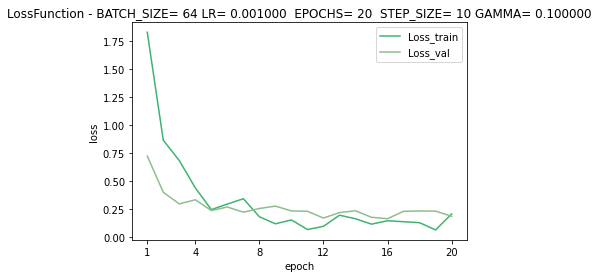

[0.3772475795297372, 0.7299446749654218, 0.838865836791148, 0.8869294605809128, 0.9149377593360996, 0.9266943291839558, 0.941908713692946, 0.9557399723374828, 0.9619640387275242, 0.9695712309820194, 0.9768326417704011, 0.9754495159059474, 0.9761410788381742, 0.979253112033195, 0.9768326417704011, 0.9764868603042877, 0.9740663900414938, 0.9778699861687413, 0.983402489626556, 0.9802904564315352]
0.8381742738589212


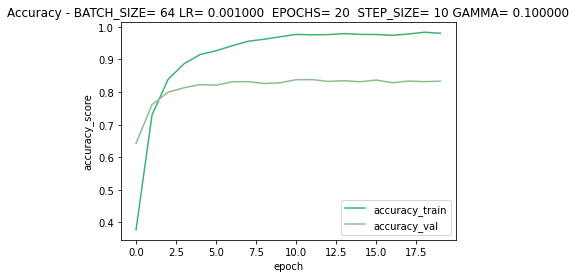

In [13]:
#pedrone

tit = 'LossFunction - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' % (BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
punti=[1,4,8,12,16,20]
x=np.linspace(1,20,20)
plt.plot(x,loss_vector,color='mediumseagreen')
plt.plot(x,loss_val,color='darkseagreen')
plt.title(tit)
plt.xticks(punti)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss_train','Loss_val'],loc='upper right')
plt.show()
tit_2='Accuracy - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' %(BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
plt.plot(acc_train,color='mediumseagreen')
plt.plot(tot_accuracy,color='darkseagreen')
plt.legend(['accuracy_train','accuracy_val'],loc='best')
plt.title(tit_2)
plt.xlabel('epoch')
plt.ylabel('accuracy_score')
print(acc_train)
print(best_accuracy)

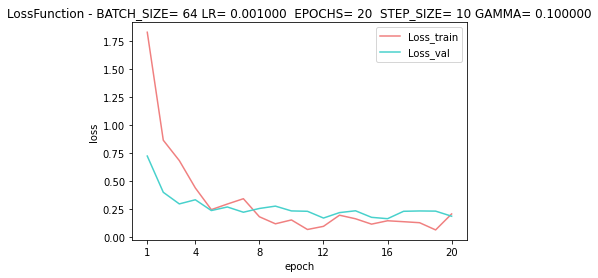

[0.3772475795297372, 0.7299446749654218, 0.838865836791148, 0.8869294605809128, 0.9149377593360996, 0.9266943291839558, 0.941908713692946, 0.9557399723374828, 0.9619640387275242, 0.9695712309820194, 0.9768326417704011, 0.9754495159059474, 0.9761410788381742, 0.979253112033195, 0.9768326417704011, 0.9764868603042877, 0.9740663900414938, 0.9778699861687413, 0.983402489626556, 0.9802904564315352]
0.8381742738589212


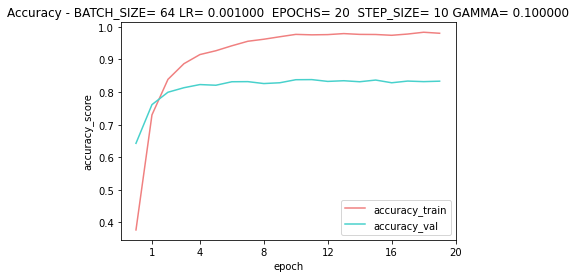

In [14]:
tit = 'LossFunction - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' % (BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
x=np.linspace(1,20,20)
punti=[1,4,8,12,16,20]
plt.plot(x,loss_vector,color='lightcoral')
plt.plot(x,loss_val,color='mediumturquoise')
plt.xticks(punti)
plt.title(tit)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss_train','Loss_val'],loc='upper right')
plt.show()
tit_2='Accuracy - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' %(BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
plt.plot(acc_train,color='lightcoral')
plt.plot(tot_accuracy,color='mediumturquoise')
plt.legend(['accuracy_train','accuracy_val'],loc='best')
plt.title(tit_2)
plt.xlabel('epoch')
plt.ylabel('accuracy_score')
plt.xticks(punti)
print(acc_train)
print(best_accuracy)

In [15]:
#TEST
net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False)

running_corrects = 0
for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

  0%|          | 0/46 [00:00<?, ?it/s]

2893
2893


100%|██████████| 46/46 [00:10<00:00,  4.36it/s]

2893
Test Accuracy: 0.8444521258209471
